In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import scipy.stats as stats

%matplotlib inline
plt.style.use('seaborn')

## About:
This notebook explores the methods used in the paper by Omari et al. to fit a statistical distribution to car insurance severity from a dataset available online.

It was my intention to replicate the study using python, but unfortunately the datasets used in the paper are not available outside of R. Instead I used a dataset posted on a public forum as a basis for this study.

Link to Paper: https://www.researchgate.net/publication/323379447_Modeling_the_Frequency_and_Severity_of_Auto_Insurance_Claims_Using_Statistical_Distributions

Link to post containing dataset (used Emcien data): https://opendata.stackexchange.com/questions/7807/where-can-i-find-automobile-insurance-claims-data-set

### Initial Data Analysis

In [2]:
auto_claims = pd.read_csv('Auto_Insurance_Claims_Sample.csv')

In [3]:
auto_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 26 columns):
Customer                         9134 non-null object
Country                          9134 non-null object
State Code                       9134 non-null object
State                            9134 non-null object
Claim Amount                     9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective To Date                9134 non-null object
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location Code                    9134 non-null object
Marital Status                   9134 non-null object
Monthly Premium Auto             9134 non-null int64
Months Since Last Claim          9134 non-null int64
Months Since Policy Inception  

No null entries in the data

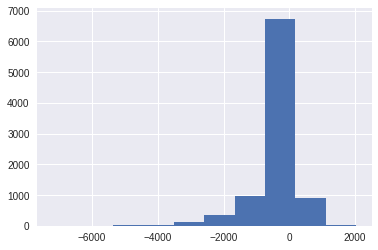

In [4]:
auto_claims['claim_amount_diff'] = auto_claims['Total Claim Amount'] - auto_claims['Claim Amount']
auto_claims['claim_amount_diff'].hist()

Curiously the Total Claim amount differs from the Claim amount in various cases. Why does this happen? I'll put this aside for now and perhaps come back to it later

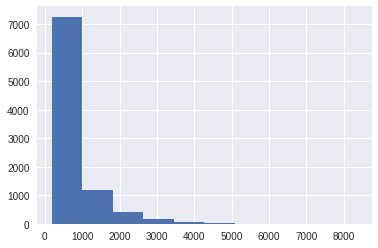

In [5]:
auto_claims['Claim Amount'].hist()

Claim amount distribution is right-skewed as expected

In [6]:
severity = auto_claims['Claim Amount'].to_numpy()

In [7]:
severity_stats = {
    'count' :  len(severity),
    'min' : severity.min(),
    'max' : severity.max(),
    'mean' : severity.mean(),
    'median' : np.median(severity),
    'std' : np.std(severity),
    'skewness' : stats.skew(severity),
    'kurtosis' : stats.kurtosis(severity),
}

In [8]:
for stat, val in severity_stats.items():
    print(stat.ljust(10), str(val).rjust(3))

count      9134
min        189.8007675
max        8332.538118999999
mean       800.4940474987081
median     578.0182197
std        687.0591477654132
skewness   3.031782271327885
kurtosis   13.815310695287437


As the original data is heavily skewed, let's take the log of the severity values

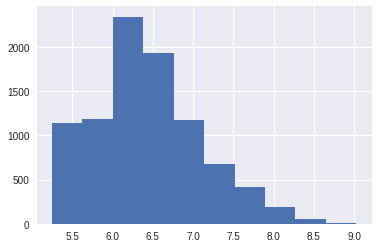

In [9]:
log_severity = np.log(severity)

plt.hist(log_severity)
plt.show()

It looks like we the log of the data is more likely to be fit to a distribution than the original values.

For an experiment, let's also take the log of log_severity

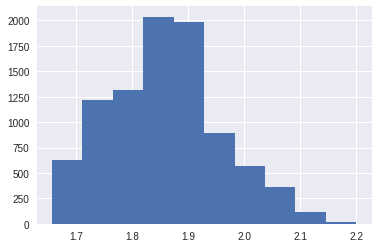

In [10]:
log_log_severity = np.log(log_severity)

plt.hist(log_log_severity)
plt.show()

### Fit Distributions
Distributions to test:
* Exponential
* Gamma
* lognormal
* Weibull
* Pareto

In [11]:
distributions = ['expon', 'gamma', 'lognorm', 'pareto', 'exponweib']
cm = cmap.get_cmap('Dark2' ,len(distributions))
colors = cm(range(len(distributions)))

*Note:* The fit method of the distributions uses MLE to estimate the parameter

In [12]:
def fit_plot_distributions(dataset, title, distributions=distributions):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.hist(dataset, density=True, alpha=0.3)
    
    x_min, x_max = dataset.min(), dataset.max()
    x = np.linspace(x_min, x_max, 100)
    
    fitted_dists = {}
    for name,color in zip(distributions, colors):
        dist = getattr(stats, name)
        params = dist.fit(dataset)
        frozen_dist = dist(*params)
        fitted_dists[name] = frozen_dist
        ax.plot(x, frozen_dist.pdf(x), c=color ,label=name)
    
    ax.set_ylabel('pdf')
    ax.set_title(f'Distribution fits for {title}')
    ax.legend(loc='best', frameon=False)
    plt.show()
    return fitted_dists

/home/carlos/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


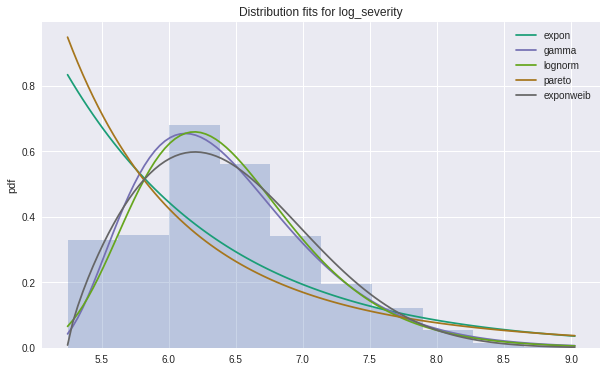

In [13]:
log_sev_dists = fit_plot_distributions(log_severity, 'log_severity')

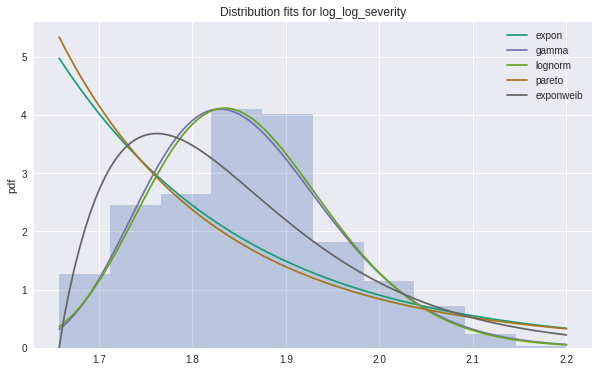

In [14]:
log_log_sev_dists = fit_plot_distributions(log_log_severity, 'log_log_severity')

In both cases gamma and lognorm distribution looks like a closer fit. However this heuristic method is not reliable, let's examine some metrics and perform goodness of fit tests

### Information Criteria

Interesting article on AIC: www.r-bloggers.com/how-do-i-interpret-the-aic

Recall that the log likelihood function for a parameter $\theta$ is 
$$ l(\theta) = \sum_{i=1}^{n}\ln{f(x_i|\theta)} $$
Hence we can use *stats.logpdf* to calculate the loglikelihood of each point in our dataset and use this value to calculate the Akaike Information Criterion (*k=* # of parameters in the distribution)
$$ \text{AIC} = 2k - 2l(\theta) $$
Finally, the model with smallest AIC is the one that best fits the data

And the BIC is defined as
$$ \text{BIC} = k\ln(n) - 2l(\theta) $$
Where n is the number of observations in the sample. Again lowest values of BIC are better

In [15]:
def llf(distribution, dataset):
    return np.sum(distribution.logpdf(dataset))

def k_parameters(distribution):
    return len(distribution.args)

def aic(distribution, dataset):
    return 2*k_parameters(distribution) -2*llf(distribution, dataset)

def bic(distribution, dataset):
    return k_parameters(distribution)*np.log(len(dataset)) -2*llf(distribution, dataset)

def create_parameter_df(distribution_dict, dataset):
    params = {'llf':[] ,'aic':[], 'bic':[]}
    idx = []
    for name, dist in distribution_dict.items():
        params['llf'].append(llf(dist, dataset))
        params['aic'].append(aic(dist, dataset))
        params['bic'].append(bic(dist, dataset))
        idx.append(name)
    return pd.DataFrame(params, index=idx)

log(severity)

log(log(severity))

In [16]:
# Table with results for log_severity
(create_parameter_df(log_sev_dists, log_severity)
     .sort_values(['aic', 'bic'], ascending=False))

llf           aic           bic
pareto    -11449.996807  22905.993614  22927.352891
expon     -10799.338493  21602.676986  21616.916504
lognorm    -8723.971622  17453.943244  17475.302521
gamma      -8667.003337  17340.006673  17361.365950
exponweib  -8529.403761  17066.807523  17095.286559

In [17]:
# Table with results for log_log_severity
(create_parameter_df(log_log_sev_dists, log_log_severity)
     .sort_values(['aic', 'bic'], ascending=False))

llf           aic           bic
pareto     5137.952146 -10269.904293 -10248.545016
expon      5521.412625 -11038.825250 -11024.585732
exponweib  7654.688723 -15301.377445 -15272.898409
lognorm    8236.129404 -16466.258807 -16444.899530
gamma      8255.375075 -16504.750149 -16483.390872

### Goodness of fit tests

We'll start by stating the hypotheses
$$ \text{H}_0: \text{The claims data sample follow a given distribution}$$
$$ \text{H}_1: \text{The claims data sample does not follow the given distribution}$$

#### Kolmogorov-Smirnov test
The K-S test compares an empirical distribution against a given distribution based on their CDFs as the CDF uniquely characterizes a distribution (PDF is obtained by differentiating CDF).

The test returns a statistic that is equal the largest vertical distance between the empirical and the theoretical distribution.

In [18]:
from scipy.stats import kstest

def get_ks_results(distribution_dict, dataset):
    results = {'ks_statistic':[], 'p-value':[]}
    idx = []
    for name, dist in distribution_dict.items():
        idx.append(name)
        ks = kstest(dataset, name, args=dist.args)
        results['ks_statistic'].append(ks[0])
        results['p-value'].append(ks[1])
    return pd.DataFrame(results, index=idx)

log(severity)

log(log(severity))

In [19]:
get_ks_results(log_sev_dists, log_severity)

ks_statistic       p-value
expon          0.215955  0.000000e+00
gamma          0.055819  3.819232e-25
lognorm        0.057427  1.369231e-26
pareto         0.235643  0.000000e+00
exponweib      0.044495  3.923315e-16

In [20]:
get_ks_results(log_log_sev_dists, log_log_severity)

ks_statistic        p-value
expon          0.235700   0.000000e+00
gamma          0.057889   5.179531e-27
lognorm        0.057456   1.290155e-26
pareto         0.245890   0.000000e+00
exponweib      0.145617  1.182884e-168

*P-value:* Given that the null hypothesis is true, the p-value is the probability that we will encounter a sample as extreme, or more extreme than the one given. In other words, a small p-value, tells us that our sample is common enough according to the given distribution.

Thus, from the tables above we fail to reject the null-hypothesis and all of the distributions seem like a good fit.

*Note: Perhaps i'm doing something wrong here, it seems unlikely expon and pareto are good fits for the data?*

#### Anderson-Darling test
Tests whether a sample of data is drawn from a given probability distribution

In [21]:
from scipy.stats import anderson

def get_ad_results(distribution_dict, dataset):
    results = {'ad_statistic':[], 'critical_values':[], 'significance':[]}
    idx = []
    for name, dist in distribution_dict.items():
        ad = anderson(dist.rvs(size=len(dataset)), 'norm')
        results['ad_statistic'].append(ad[0])
        results['critical_values'].append(ad[1])
        results['significance'].append(ad[2])
        idx.append(name)
    return pd.DataFrame(results, index=idx)

In [22]:
get_ad_results(log_sev_dists, log_severity)

ad_statistic                      critical_values  \
expon        414.773076  [0.576, 0.656, 0.787, 0.918, 1.092]   
gamma         95.178284  [0.576, 0.656, 0.787, 0.918, 1.092]   
lognorm       68.593792  [0.576, 0.656, 0.787, 0.918, 1.092]   
pareto       690.301527  [0.576, 0.656, 0.787, 0.918, 1.092]   
exponweib     52.837321  [0.576, 0.656, 0.787, 0.918, 1.092]   

                          significance  
expon      [15.0, 10.0, 5.0, 2.5, 1.0]  
gamma      [15.0, 10.0, 5.0, 2.5, 1.0]  
lognorm    [15.0, 10.0, 5.0, 2.5, 1.0]  
pareto     [15.0, 10.0, 5.0, 2.5, 1.0]  
exponweib  [15.0, 10.0, 5.0, 2.5, 1.0]

In [23]:
get_ad_results(log_log_sev_dists, log_log_severity)

ad_statistic                      critical_values  \
expon        423.310726  [0.576, 0.656, 0.787, 0.918, 1.092]   
gamma         32.788727  [0.576, 0.656, 0.787, 0.918, 1.092]   
lognorm       23.178058  [0.576, 0.656, 0.787, 0.918, 1.092]   
pareto       566.158234  [0.576, 0.656, 0.787, 0.918, 1.092]   
exponweib    195.546737  [0.576, 0.656, 0.787, 0.918, 1.092]   

                          significance  
expon      [15.0, 10.0, 5.0, 2.5, 1.0]  
gamma      [15.0, 10.0, 5.0, 2.5, 1.0]  
lognorm    [15.0, 10.0, 5.0, 2.5, 1.0]  
pareto     [15.0, 10.0, 5.0, 2.5, 1.0]  
exponweib  [15.0, 10.0, 5.0, 2.5, 1.0]

From scipy's documentation:

*If the returned statistic is larger than these critical values then for the corresponding significance level, the null hypothesis that the data come from the chosen distribution can be rejected. The returned statistic is referred to as ‘A2’ in the references.*

Putting the two tests together:

In [24]:
log_ks = get_ks_results(log_sev_dists, log_severity).iloc[:, 0]
log_ad = get_ad_results(log_sev_dists, log_severity).iloc[:, 0]

log_results_df = (pd
    .concat([log_ks, log_ad], axis=1)
    .sort_values('ks_statistic', axis=0, ascending=False)
)
log_results_df

ks_statistic  ad_statistic
pareto         0.235643    735.210683
expon          0.215955    417.446905
lognorm        0.057427     63.882563
gamma          0.055819     95.148283
exponweib      0.044495     49.996203

In [25]:
log_log_ks = get_ks_results(log_sev_dists, log_severity).iloc[:, 0]
log_log_ad = get_ad_results(log_sev_dists, log_severity).iloc[:, 0]

log_log_results_df = (pd
    .concat([log_log_ks, log_log_ad], axis=1)
    .sort_values('ks_statistic', axis=0, ascending=False)
)
log_log_results_df

ks_statistic  ad_statistic
pareto         0.235643    740.560639
expon          0.215955    427.719176
lognorm        0.057427     72.316109
gamma          0.055819    101.006418
exponweib      0.044495     55.953510

Looks like exponweib was the most appropriate fit for this dataset.

Next steps:

* Review theory behind above analysis and correct any errors
* Suppose we now have an appropriate distribution to fit to our data. How do we translate it  into a forecast for total cost of claims? Or how do we put it in practice?
* Once the above is done, can we compare it to a ML model that forecasts total cost of claims?